# Schelling's Model of Segregation

In [2]:
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple, Dict, Callable
import random as rand
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# load dataset from drive 
#from google.colab import drive
#drive.mount('/content/drive')

A simulation of Schelling's model of segregation is implemented.  
A concise explanation on how the model is specified as well as another simulation can, for instance, be found here:

http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/

#### Grid Creation 
First I created a 2D grid in which the simulation will take place. A function returns a numpy array of the given shape (rows, columns). Cells with a red agent are marked with the value 1, cells with a blue agent with value 2, empty cells with a 0.

In [7]:
def init_grid(shape: Tuple[int,int], share_red: float, share_blue: float) -> np.ndarray:
    """
    :param shape: integer tuple, shape of grid
    :param share_red: percent share of red nodes in the data
    :param share_blue: percent share of blue nodes in the data 
    :                : -> note that blue+red shares should be <1 as empty cells are needed
    :return: 2D numpy array
    """
    
    # check that red + blue < 1
    if share_red + share_blue >= 1:
        raise ValueError('share_red + share_blue must be < 1')
    
    # initialize grid with given shape
    rows,cols = shape
    grid = np.zeros(shape=shape, dtype=int)
    num_red = round(share_red * grid.size)
    num_blue = round(share_blue * grid.size)
    
    # randomly fill in grid with red, then blue agents
    while(num_red > 0):
        r = rand.randrange(rows)
        c = rand.randrange(cols)
        if grid[r][c] == 0:
            grid[r][c] = 1 # red
            num_red -= 1
    while(num_blue > 0):
        r = rand.randrange(rows)
        c = rand.randrange(cols)
        if grid[r][c] == 0:
            grid[r][c] = 2 # blue
            num_blue -= 1

    return grid
    
    raise NotImplementedError

#### b) Visualization

A grid with $30x30$ rows/colums, 40% red cells, 50% blue cells, and 10% empty cells is created and saved into a variable called ```initial_grid```. Further, a visualization marks empty cells being white, cells of red agents as red, and cells of blue agents as blue.

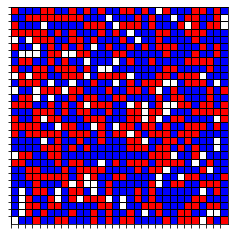

In [8]:
initial_grid = init_grid((30,30), 0.4, 0.5)

# assign colors to values
cmap = {0:np.array([255,255,255]), #white
        1:np.array([255,0,0]), #red
        2:np.array([0,0,255])} #blue
# create a 3d array to hold color dimension
grid_3d = np.ndarray(shape=(initial_grid.shape[0],initial_grid.shape[1], 3), dtype=int)
for i in range (0, initial_grid.shape[0]):
    for j in range (0, initial_grid.shape[1]):
        grid_3d[i][j] = cmap[initial_grid[i][j]]

plt.imshow(grid_3d)
ax = plt.gca()
ax.set_xticks(np.arange(-.6, 29, 1))
ax.set_yticks(np.arange(-.6, 29, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black',linestyle='-',linewidth=1)
plt.savefig('initial_grid.png')

# used the site below for help coloring the grid: 
# https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
# used the site below for help adding grid lines in the right places: 
# https://www.tutorialspoint.com/adjusting-gridlines-and-ticks-in-matplotlib-imshow

#### c) The Update Step 

A function performs a single update step of Schelling's model. In that scenario, each step should work as follows:
* first, one iterates over the full grid to identify all agents that are currently not satisfied. Recall: an agent is satisfied if a fraction $\geq pp$ of their neighbors is from the same group, with $pp$ denoting the preferred proportion.
* afterwards, these unhappy agents are relocated in sequence to a randomly chosen empty cell. In that process, the cell that one agents leaves becomes vacated and should become available as empty cell for the next unsatisfied agent. Conversely, after moving to an empty cell, this cell is then occupied and not available for relocation anymore. While relocating, one does not check anymore whether the agent would be satisfied in the new location.

This function returns a boolean variable which returns `True` if and only if all agents of the input grid were satisfied.

In [9]:
def schelling_step(grid: np.ndarray, pp: float) -> Tuple[bool, np.ndarray]:
    """
    :param grid: 2D numpy array specifying the current state (grid) in the simulation
    :param pp: preferred poportion of neighbors of own class, should be between 0 and 1
    :
    :return: 1. bool specifying whether or not simulation has converged, i.e., all agents are satisfied
    :        2. 2D numpy array that specifies the state of the grid after the update step ->  
    """
    grid_copy = np.copy(grid)
    # identify agents that are not satisfied
    unsat_agents = []
    empty_cells = []
    for row in range(0, grid_copy.shape[0]):
        for col in range(0, grid_copy.shape[1]):
            if grid_copy[row][col]==0: #empty cell
                empty_cells.append([row,col])
            else:
                nbrs = find_nbrs(grid_copy, row, col)
                if (sat_agent(nbrs, pp, grid_copy[row][col]) == False): #if central agent is not satisfied
                    # add unsatisfied agent to list
                    unsat_agents.append([row,col]) #[row,col] is a list, (row,col) is a tuple
                else:
                    continue
    
    # relocate each unsatisfied agent to randomly chosen empty cells
    for agent in unsat_agents:
        # randomly choose empty cell
        new_location = rand.choice(empty_cells)
        empty_cells.remove(new_location)
        # relocate agent
        agent_color = grid_copy[agent[0]][agent[1]]
        grid_copy[agent[0]][agent[1]] = 0 # agent moves out
        empty_cells.append(agent) # append agent's old location to list of empty cells
        grid_copy[new_location[0]][new_location[1]] = agent_color # agent moves in
        
    # check if all agents are now satisfied
    satisfaction = True
    for row in range(0, grid_copy.shape[0]):
        for col in range(0, grid_copy.shape[1]):
            if grid_copy[row][col]!=0: #non-empty cells
                nbrs = find_nbrs(grid_copy, row, col)
                if (sat_agent(nbrs, pp, grid_copy[row][col]) == False):
                    satisfaction = False

    return (satisfaction, grid_copy)
    
    raise NotImplementedError
    
def find_nbrs(grid: np.ndarray, row:int, col:int) -> np.ndarray:
    """
    :param grid: 2D numpy array containing all agents
    :param row: indicating central agent's row position in grid
    :param col: indicating central agent's column position in grid
    :return: numpy array containing central agent and its neighbours 
    """
    # set boundaries
    left = max(0, row-1)
    right = min(row+2, grid.shape[0])
    bottom = max(0, col-1)
    top = min(col+2, grid.shape[1])
    # find neighbours
    nbrs = grid[left:right, bottom:top]
    return nbrs

def sat_agent(nbrs:np.ndarray, pp:float, agent_class:int) -> bool:
    """ 
    :param nbrs: 2D numpy array containing central agent and its neighbours (max 3x3 cells)
    :param pp: preferred proportion of neighbours of its own class (0 < pp < 1)
    :param agent_class: central agent class
    :return: bool specifying whether the central agent is satisfied given pp and its neighbours
    """
    # count number of blue and red agents in nbrs
    red_nbrs = 0
    blue_nbrs = 0
    for row in range(0, nbrs.shape[0]):
        for col in range(0, nbrs.shape[1]):
            if nbrs[row][col]==1: #red
                red_nbrs+=1
            elif nbrs[row][col]==2: #blue
                blue_nbrs+=1

    # compare proportion of ingroup neighbours (same class) to preferred proportion pp
    num_nbrs = red_nbrs + blue_nbrs - 1 #total number of neighbours (-1 to exclude central agent)
    if num_nbrs > 0:
        if agent_class == 1: #red
            red_nbrs-=1
            if (red_nbrs/num_nbrs) >= pp:
                return True
            else: return False
        elif agent_class == 2: #blue
            blue_nbrs-=1
            if (blue_nbrs/num_nbrs) >= pp:
                return True 
            else: return False
    elif num_nbrs == 0: #only central agent
        return True

#### d) A Full Simulation of Schelling's Model 

A function performs a full simulation of Schelling's model given a specific initial state, by performing steps until the maximum number of steps `n_max` is reached or if the model has converged, i.e., all agents are now satisfied. 

In [10]:
def simulate_schelling(grid: np.ndarray, pp: float, n_max: int) -> np.ndarray:
    """
    :param grid: initial grid to start simulation with (2D numpy array)
    :param pp: preferred poportion of neighbors of own class
    :param n_max: maximum number of iteration steps
    :
    :return: 2D numpy array
    """
    
    num_steps = 0
    current_grid = grid
    while(num_steps < n_max):
        step_result = schelling_step(current_grid, pp)
        current_grid = step_result[1] # update current grid
        if step_result[0]: # grid converged: all agents satisfied 
            print('number of steps completed:', num_steps)
            return current_grid
        else:
            num_steps+=1
    print('number of steps completed:', num_steps)
    return current_grid
    
    raise NotImplementedError

#### e) Running a Full Simulation

Implementation from d) on the `initial_grid` created in b) is applied to run the model with a preferred proportion `pp=0.5` for up to `n_max=100` steps.

number of steps completed: 14


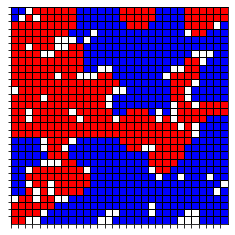

In [11]:
final_grid = simulate_schelling(initial_grid, 0.5, 100)

# assign colors to values
cmap = {0:np.array([255,255,255]), #white
        1:np.array([255,0,0]), #red
        2:np.array([0,0,255])} #blue
# create a 3d array to hold color dimension
final_grid_3d = np.ndarray(shape=(final_grid.shape[0],final_grid.shape[1], 3), dtype=int)
for i in range(0, final_grid.shape[0]):
    for j in range(0, final_grid.shape[1]):
        final_grid_3d[i][j] = cmap[final_grid[i][j]]

plt.imshow(final_grid_3d)
ax = plt.gca()
ax.set_xticks(np.arange(-.6, 29, 1))
ax.set_yticks(np.arange(-.6, 29, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black',linestyle='-',linewidth=1)
plt.savefig('final_grid.png')

# used the site below for help coloring the grid: 
# https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
# used the site below for help adding grid lines in the right places: 
# https://www.tutorialspoint.com/adjusting-gridlines-and-ticks-in-matplotlib-imshow